<a href="https://www.kaggle.com/code/demonicak/imagecaptioning?scriptVersionId=288535503" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [58]:
# Core
import os
import glob
import gc
import string
import numpy as np
import matplotlib.pyplot as plt
from time import time
from PIL import Image
from tqdm import tqdm

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, LSTM, Bidirectional,
    BatchNormalization, LayerNormalization, Attention,
    Activation, Flatten, Reshape, Lambda ,Layer,GRU,Concatenate
)

# Visualization
%matplotlib inline

# nlp
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import random

load the last session


In [59]:
# import dill
# dill.load_session('/kaggle/working/state.db')

Layers compute in float16

Weights are stored in float32

In [111]:
set_global_policy('mixed_float16')
# tf.config.experimental.set_synchronous_execution(True)

In [61]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print("GPU Devices:", gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
# tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical devices cannot be modified after being initialized


# Step 2 : Data Loading and Pre-Processing

In [62]:
token_path = "/kaggle/input/flickr8k/captions.txt"
images_path = "/kaggle/input/flickr8k/Images/"
glove_path = '/kaggle/input/glove6b200d/'

In [63]:
doc = open(token_path,'r').read()
print(doc[:500])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


**So we can see the format in which our image id’s and their captions are stored.
Next, we create a dictionary named “descriptions” which contains the name of the image as keys and a list of the 5 captions for the corresponding image as values.**

In [64]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split(',',1)
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          # print(image_desc)
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [65]:
imagecount=len(descriptions)
caption_count=0
for x,k in descriptions.items():
    caption_count+=len(k)
    # image_count
avg_captions_count=caption_count/imagecount
print(avg_captions_count,imagecount)

4.999505684626792 8092


** basic text clean to get rid of punctuation and convert our descriptions to lowercase.**

In [66]:
table = str.maketrans('','', string.punctuation)
def clean_caption(desc):
    desc = desc.lower()
    desc = desc.translate(table)
    desc = ' '.join(desc.split())  # remove extra spaces
    return desc

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_caption(desc_list[i])
       

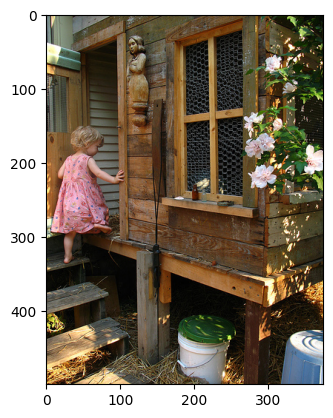

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

In [67]:
## Lets visualize and example image
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [68]:
vocabulary = set()

for desc_list in descriptions.values():
    for desc in desc_list:
        vocabulary.update(desc.split())

print(f'Original Vocabulary Size: {len(vocabulary)}')


Original Vocabulary Size: 8829


In [69]:
img_names=list(descriptions.keys())
data=img_names[1:]
dataset = set(data)

In [70]:
len(data),len(dataset)

(8091, 8091)

In [71]:
TRAIN_SIZE=0.6
TEST_SIZE=0.2

In [72]:
train = data[:int(TRAIN_SIZE*len(dataset))]
val=data[int(TRAIN_SIZE*len(dataset)):-int((TEST_SIZE)*len(dataset))]
test=data[-int((TEST_SIZE)*len(dataset)):]

In [73]:
print('train len:',len(train),'\n val len',len(val),'\n test len',len(test),'\n total len',len(train)+len(val)+len(test))

train len: 4854 
 val len 1619 
 test len 1618 
 total len 8091


In [74]:
# For development, use a smaller subset of the data
# train = train[:1000]  # Only use first 1000 images for debugging

**Now, we will load the descriptions of the training images into a dictionary. However, we will add two tokens in every capation, which are 'startseq' and 'endseq'.**


In [75]:
train_descriptions = {}
val_descriptions = {}
test_descriptions = {}

for key, desc_list in descriptions.items():
    image_id=key
    for desc in desc_list:
        # print(desc)
        image_desc='startseq ' + desc + ' endseq'
        if image_id in train:
            train_descriptions.setdefault(image_id, []).append(image_desc)
        elif image_id in val:
            val_descriptions.setdefault(image_id, []).append(image_desc)
        elif image_id in test:
            test_descriptions.setdefault(image_id, []).append(image_desc)


In [76]:
all_descriptions = {**train_descriptions, **val_descriptions, **test_descriptions}

In [77]:
all_train_captions = []
for key, values in train_descriptions.items():
    for cap in values:
        all_train_captions.append(cap)



**To make our model more robust, we will reduce our vocabulary to only those words which occur atleast 10 times in the entire corpus**

In [78]:
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 2255


**Now, we will create two dictionaries to map words to an index and vice versa. Also, we will append 1 to our vocabulary since we append 0 to make all the captions of equal lengths**

In [79]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [80]:
vocab_size

2256

**Hence we now have a vocab size of {vocab_size}.**


**We also need to find out what maximum length of a caption can be since we can't have have captions of arbitary length.**

In [81]:
all_desc = list()
for key in all_descriptions.keys():
    [all_desc.append(d) for d in all_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length:',max_length)

Description Length: 38


# Step 3: Glove Embeddings

**Word vectors map words to a vector space, where similar words are clustered together and different words are separated.
The basic premise behind Glove is that we can derive sematic relationships between words from the coouucrence matrix.**

**For our model, we will map all the 38-word long caption to a 200-dimension vector using Glove.**

In [82]:
embeddings_index = {}
glove_path = '/kaggle/input/glove6b200d'
glove_file = os.path.join(glove_path, 'glove.6B.200d.txt')

# Count total lines first
with open(glove_file, encoding="utf-8") as f:
    total_lines = sum(1 for _ in f)

# Now parse with progress bar
with open(glove_file, encoding="utf-8") as f:
    for line in tqdm(f, total=total_lines, desc="Loading GloVe embeddings"):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


Loading GloVe embeddings: 100%|██████████| 400000/400000 [00:15<00:00, 25460.98it/s]


**Now, we make metrix of shape(1660,220) consisting of our vocabulary and the 200-d vector.**

In [83]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Step 4 : Model building and Training

**A approach we have adopted is transfer learning using Inception v-3 network which is pre-trained on the Image-Net dataset.**

In [84]:
def get_image_dimensions_fast(image_path):
    img = Image.open(image_path)
    return img.width, img.height

In [85]:
BATCH_SIZE =64  # Adjust based on available memory

Input image  → (299, 299, 3)
Output feat  → (2048,)

In [86]:
# model = InceptionV3(weights='imagenet',include_top=False, pooling='avg')
# feature_extractor = Model(model.input, model.layers[-2].output)

Output feature shape → (1536,)

In [87]:
from tensorflow.keras.applications import EfficientNetB3

feature_extractor = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    pooling="avg"
)
feature_extractor.trainable = False 
FEATURE_DIM=1536

**Since we are using Inception V-3 , we nedd to pre-process our inputs before feeding it into the model.
Hence, we need to defince a preprocess function to reshape the images(299 x 299) and feed the preprocess_input() function.**

**Now, we can go ahead with training and testing images i.e we can extract the images vectors of shape (2048 ,)**

In [88]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

class ImageFeatureEncoder:
    def __init__(
        self,
        feature_extractor,
        images_path,
        image_size=(300, 300),
        BATCH_SIZE=32
    ):
        self.feature_extractor = feature_extractor
        self.images_path = images_path
        self.image_size = image_size
        self.BATCH_SIZE = BATCH_SIZE

    def _load_and_preprocess_image(self, img_path):
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, self.image_size)
        image = preprocess_input(image)
        return image

    def _build_dataset(self, image_paths):
        dataset = tf.data.Dataset.from_tensor_slices(image_paths)
        dataset = dataset.map(
            self._load_and_preprocess_image,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

    def encode(self, image_keys, verbose=1):
        image_paths = np.array(
            [self.images_path + x + ".jpg" for x in image_keys],
            dtype=str
        )

        dataset = self._build_dataset(image_paths)

        features = self.feature_extractor.predict(
            dataset,
            verbose=verbose
        )

        encoding = {
            image_paths[i]: features[i]
            for i in range(len(image_paths))
        }

        return encoding


In [89]:
all_image_keys = sorted(set(train) | set(val) | set(test))
encoder = ImageFeatureEncoder(
    feature_extractor=feature_extractor,
    images_path=images_path,
    image_size=(300, 300),
    BATCH_SIZE=32
)
all_features = encoder.encode(all_image_keys)
np.save("efficientnetb3_all_features.npy", all_features)

253/253 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step


In [90]:
# print("train sample:", next(iter(train)))
# print("feature key sample:", next(iter(all_features.keys())))


In [91]:
all_features = np.load(
    "efficientnetb3_all_features.npy",
    allow_pickle=True
).item()
train_features = {k: all_features[images_path+k+'.jpg'] for k in train}
val_features   = {k: all_features[images_path+k+'.jpg'] for k in val}
test_features  = {k: all_features[images_path+k+'.jpg'] for k in test}

In [ ]:
table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(train_features.keys())),
        values=tf.constant(list(train_features.values()), dtype=tf.float16)
    ),
    default_value=tf.zeros([FEATURE_DIM], tf.float16)
)

In [92]:
len(train_features),len(val_features),len(test_features),len(train_features)+len(val_features)+len(test_features)

(4854, 1619, 1618, 8091)

In [93]:
sample_key = list(train_features.keys())[0]
print(f"Feature dtype: {train_features[sample_key].dtype}")
print(f"Feature shape: {train_features[sample_key].shape}")

Feature dtype: float16
Feature shape: (1536,)


# Step 5 : Model Training

**Now let’s define our model.**

**We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:**

**Processing the sequence from the text**

**Extracting the feature vector from the image**

**Decoding the output using softmax by concatenating the above two layers**

**Input_3 is the partial caption of max length 34 which is fed into the embedding layer. This is where the words are mapped to the 200-d Glove embedding. It is followed by a dropout of 0.5 to avoid overfitting. This is then fed into the LSTM for processing the sequence.**

**Input_2 is the image vector extracted by our InceptionV3 network. It is followed by a dropout of 0.5 to avoid overfitting and then fed into a Fully Connected layer.**

**Both the Image model and the Language model are then concatenated by adding and fed into another Fully Connected layer. The layer is a softmax layer that provides probabilities to our 1660 word vocabulary.**





**Before training the model we need to keep in mind that we do not want to retrain the weights in our embedding layer (pre-trained Glove vectors).**

**Next, compile the model using Categorical_Crossentropy as the Loss function and Adam as the optimizer.**


In [94]:
def build_model():
    # --------------------
    # Image branch
    # --------------------
    image_input = tf.keras.Input(shape=(1536,), name="image_features")
    img_proj = tf.keras.layers.Dense(256, activation="relu")(image_input)
    img_proj = tf.keras.layers.Dropout(0.3)(img_proj)  # Add dropout
    img_proj = tf.keras.layers.LayerNormalization()(img_proj)

    # --------------------
    # Text branch
    # --------------------
    text_input = tf.keras.Input(shape=(max_length,), name="text_input")
    text_emb = tf.keras.layers.Embedding(
        vocab_size,
        embedding_dim,
        mask_zero=True,
        weights=[embedding_matrix],
        trainable=False
    )(text_input)

    lstm_out = tf.keras.layers.LSTM(
        256,
        return_sequences=True,
        dropout=0.3,  # Add dropout
        recurrent_dropout=0.2
    )(text_emb)

    # --------------------
    # Attention
    # --------------------
    # Query = image, Key/Value = text
    query = tf.keras.layers.Reshape((1, 256))(img_proj)
    attention =tf.keras.layers.MultiHeadAttention(
    num_heads=4,
    key_dim=256
)(query, lstm_out)
    context =  tf.keras.layers.GlobalAveragePooling1D()(attention)

    # --------------------
    # Fusion
    # --------------------
    merged = tf.keras.layers.Concatenate()([context, img_proj])
    merged = tf.keras.layers.Dense(256, activation="relu")(merged)
    merged = tf.keras.layers.Dropout(0.5)(merged)

    # --------------------
    # Output (MIXED PRECISION SAFE)
    # --------------------
    output = tf.keras.layers.Dense(
        vocab_size,
        activation="softmax",
        dtype="float32"
    )(merged)

    return tf.keras.Model(
        inputs=[image_input, text_input],
        outputs=output
    )

curr_model = build_model()
curr_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),

)

In [95]:
curr_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_features            │ (None, 1536)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, 1536)           │              0 │ image_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        393,472 │ cast_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 38)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 256)            │            512 │ dense[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 38, 200)        │        451,200 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 38)             │              0 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 38, 256)        │        467,968 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1, 256)         │      1,051,904 │ reshape[0][0],         │
│ (MultiHeadAttention)      │                        │                │ lstm[0][0],            │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ multi_head_attention[… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ global_average_poolin… │
│                           │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_2 (Cast)             │ (None, 256)            │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2256)           │        579,792 │ cast_2[0][0]           │
└──────────────────────

 Total params: 3,076,176 (11.73 MB)

 Trainable params: 2,624,976 (10.01 MB)

 Non-trainable params: 451,200 (1.72 MB)

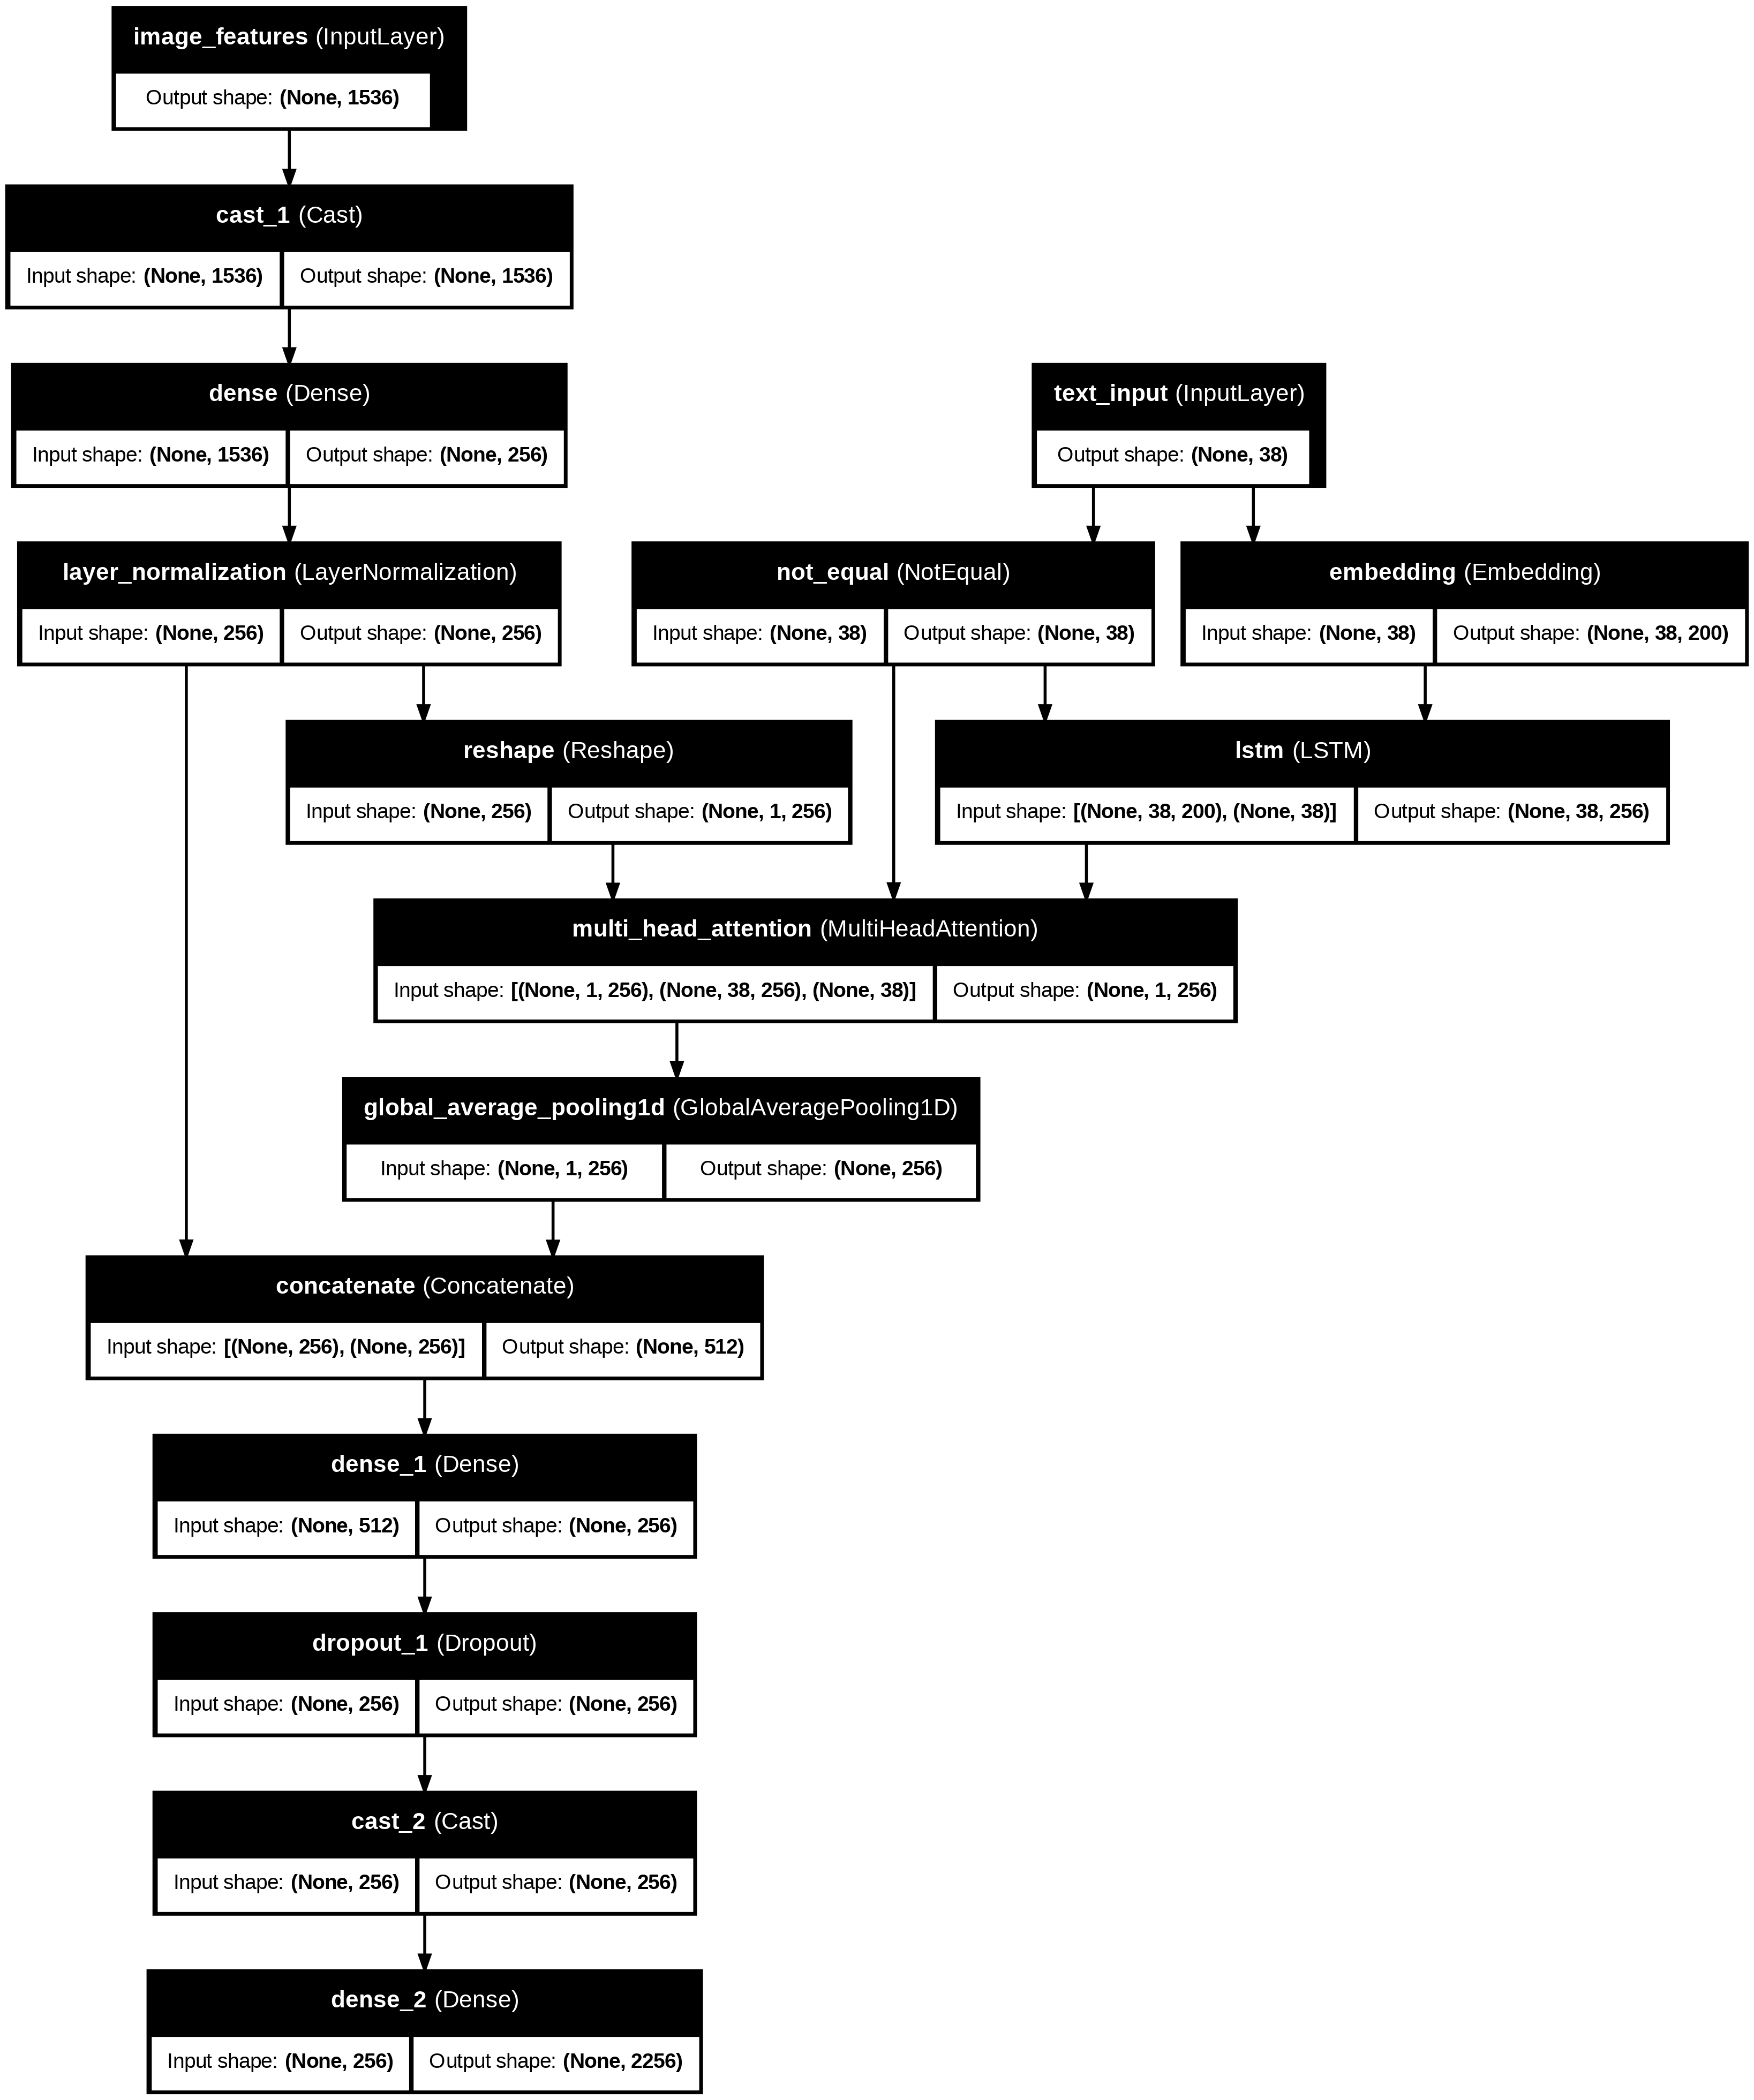

In [96]:
plot_model(curr_model, to_file="attention_caption_model_architecture.png", show_shapes=True, show_layer_names=True)

**Since our dataset has 6000 images and 40000 captions we will create a function that can train the data in batches.**


**Now , let's train our model with for 30 epochs with a BATCH_SIZE of 64 and 2612 steps per epoch.**

In [97]:
FEATURE_DIM = 1536

In [112]:
def build_samples(descriptions, features, wordtoix):
    samples = []

    for key in descriptions.keys():
        if key not in features:
            continue

        for desc in descriptions[key]:
            seq = [wordtoix[w] for w in desc.split() if w in wordtoix]
            for i in range(1, len(seq)):
                samples.append((key, seq[:i], seq[i]))

    print(f"Created {len(samples)} samples")
    return samples

def samples_to_dataset(samples, features, max_length, BATCH_SIZE, shuffle=True):

    def generator():
        for key, in_seq, out_seq in samples:

            yield key, in_seq, out_seq

    output_signature = (
        tf.TensorSpec(shape=(), dtype=tf.string),          # key
        tf.TensorSpec(shape=(None,), dtype=tf.int32),       # in_seq (ragged)
        tf.TensorSpec(shape=(), dtype=tf.int32)             # out_seq
    )

    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

    def map_fn(key, in_seq, out_seq):
        # photo = tf.numpy_function(
        #     lambda k: features[k.decode("utf-8")],
        #     [key],
        #     tf.float16
        # )
        photo = table.lookup(key)
        # photo.set_shape([FEATURE_DIM])
        # in_seq = tf.pad(in_seq, [[0, max_length - tf.shape(in_seq)[0]]])
        # in_seq = in_seq[:max_length]
        in_seq = in_seq.to_tensor(
        default_value=0,
        shape=[max_length])
        
        return (photo, in_seq), out_seq

    if shuffle:
        ds = ds.shuffle(10000)
    
    return (
        ds
        .map(map_fn, num_parallel_calls=4)
        .batch(BATCH_SIZE, drop_remainder=True)
        .repeat()
        .prefetch(1)
    )



train_samples = build_samples(train_descriptions, train_features, wordtoix)
# print(len(train_samples))
train_ds = samples_to_dataset(
    train_samples, train_features, max_length, BATCH_SIZE=64
)

options = tf.data.Options()
options.experimental_deterministic = False
train_ds = train_ds.with_options(options)


val_samples   = build_samples(val_descriptions, val_features, wordtoix)
val_ds = samples_to_dataset(
    val_samples, val_features, max_length, BATCH_SIZE=64, shuffle=False
)

NUM_TRAIN_SAMPLES,NUM_VAL_SAMPLES=len(train_samples),len(val_samples)
steps_per_epoch = NUM_TRAIN_SAMPLES // BATCH_SIZE
val_steps = NUM_VAL_SAMPLES // BATCH_SIZE

Created 278360 samples
Created 91479 samples


In [113]:
(x1, x2), y = next(iter(train_ds))
print(x1.shape)  # (64, 1536)
print(x2.shape)  # (64, max_length=38)
print(y.shape)   # (64,)

print(
    "size of train_descriptions:", len(train_descriptions),"\n",
    "size of train_features:",len (train_features),"\n",
    "size of wordtoix:",len (wordtoix),"\n",
    "max_length:", max_length,"\n",
    "BATCH_SIZE:",BATCH_SIZE,"\n",
    "vocab_size:",vocab_size,"\n",
    "images_path:",images_path
)


(64, 1536)
(64, 38)
(64,)
size of train_descriptions: 4854 
 size of train_features: 4854 
 size of wordtoix: 2255 
 max_length: 38 
 BATCH_SIZE: 64 
 vocab_size: 2256 
 images_path: /kaggle/input/flickr8k/Images/


In [100]:
# Add callbacks for better training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='image_caption_model.keras', 
        save_best_only=True, 
        monitor='loss'
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5, 
        restore_best_weights=True
    ),
      ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

In [101]:
print(train_ds)

<_OptionsDataset element_spec=((TensorSpec(shape=(64, 1536), dtype=tf.float16, name=None), TensorSpec(shape=(64, None), dtype=tf.int32, name=None)), TensorSpec(shape=(64,), dtype=tf.int32, name=None))>


In [114]:
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=-1>

In [115]:
gc.collect()
tf.keras.backend.clear_session()
with tf.device('/GPU:0'):
    history=curr_model.fit(
        train_ds,
        epochs=20,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        verbose=1
    )
curr_model.save("image_caption_model_final.keras")

Epoch 1/20
4349/4349 ━━━━━━━━━━━━━━━━━━━━ 135s 31ms/step - loss: 2.7918 - val_loss: 3.1255 - learning_rate: 5.0000e-04
Epoch 2/20
4349/4349 ━━━━━━━━━━━━━━━━━━━━ 133s 31ms/step - loss: 2.6888 - val_loss: 3.1037 - learning_rate: 5.0000e-04
Epoch 3/20
4349/4349 ━━━━━━━━━━━━━━━━━━━━ 132s 30ms/step - loss: 2.6275 - val_loss: 3.1799 - learning_rate: 5.0000e-04
Epoch 4/20
4349/4349 ━━━━━━━━━━━━━━━━━━━━ 133s 31ms/step - loss: 2.5739 - val_loss: 3.1846 - learning_rate: 5.0000e-04
Epoch 5/20
4346/4349 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.5288
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
4349/4349 ━━━━━━━━━━━━━━━━━━━━ 134s 31ms/step - loss: 2.5289 - val_loss: 3.1722 - learning_rate: 5.0000e-04
Epoch 6/20
4349/4349 ━━━━━━━━━━━━━━━━━━━━ 134s 31ms/step - loss: 2.4459 - val_loss: 3.1899 - learning_rate: 2.5000e-04
Epoch 7/20
4349/4349 ━━━━━━━━━━━━━━━━━━━━ 134s 31ms/step - loss: 2.3904 - val_loss: 3.2253 - learning_rate: 2.5000e-04


In [128]:
supermodel = load_model("/kaggle/working/image_caption_model_final.keras")

# Step 6: Greddy and Beam Search

**As the model generates a 1733 long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This method is called Greedy Search.**




In [148]:
def GreedySearch(model, image_features):
    in_text = ['startseq']

    for _ in range(max_length):
        seq = [wordtoix[w] for w in in_text if w in wordtoix]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')

        yhat = model.predict([image_features, seq], verbose=0)[0]

        next_id = np.argmax(yhat)
        next_word = ixtoword.get(next_id)

        # 🔥 stop conditions
        if next_word is None:
            break
        if next_word == 'endseq':
            break
        if next_word in in_text[-2:]:   # repetition guard
            break

        in_text.append(next_word)
    caption=in_text.join(" ")
    return in_text


**Beam Search is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions and we take the one with the highest probability and go through it till we encounter ‘endseq’ or reach the maximum caption length.**


In [118]:
def BeamSearch(model, image_features, beam_index=3, max_length=34, alpha=0.7):

    start_token = wordtoix['startseq']
    end_token   = wordtoix['endseq']

    beams = [([start_token], 0.0)]
    completed = []

    for _ in range(max_length):
        new_beams = []

        for seq, score in beams:

            if seq[-1] == end_token:
                completed.append((seq, score))
                continue

            par_caps = pad_sequences([seq], maxlen=max_length, padding='post')
            preds = model.predict([image_features, par_caps], verbose=0)[0]
            print(preds)
            preds = np.clip(preds, 1e-9, 1.0)

            top_words = np.argsort(preds)[-beam_index:]
            print(top_words)

            for w in top_words:
                # if len(seq) > 2 and w in seq[-3:]:
                #     continue

                new_seq = seq + [w]
                new_score = score + np.log(preds[w])

                new_beams.append((new_seq, new_score))

        if len(new_beams) == 0:
            break

        beams = sorted(
            new_beams,
            key=lambda x: x[1] / (len(x[0]) ** alpha),
            reverse=True
        )[:beam_index]

    # if len(completed) == 0 and len(beams) == 0:
    #     return ""

    final_seq = max(
        completed if completed else beams,
        key=lambda x: x[1] / (len(x[0]) ** alpha)
    )[0]
    
    caption = [ixtoword[i] for i in final_seq[1:]]
    print(caption)

    if 'endseq' in caption:
        caption = caption[:caption.index('endseq')]

    return ' '.join(caption)


In [107]:
# all_features = encoder.encode(all_image_keys)

253/253 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step


In [152]:
def run_caption_algo(algo_name, model, image_feature):
    algo_name = algo_name.lower()

    if algo_name == "greedy":
        seq = GreedySearch(model, image_feature)
    elif algo_name == "beam":
        seq = BeamSearch(model, image_feature)
    else:
        raise ValueError(f"Unknown algo_name: {algo_name}")

    return seq
def decode_sequence(seq, ixtoword):
    words = []
    for idx in seq:
        word = ixtoword.get(idx)
        if word is None:
            continue
        if word == 'endseq':
            break
        if word not in ('startseq',):
            words.append(word)
    return ' '.join(words)

def prediction_pipeline(
    image_path,
    algo_name,
    model,
    features,
    ixtoword,
):

    # 1️⃣ Check feature availability
    
    if image_path not in features.keys():
        return "not found"

    try:
        # 2️⃣ Fetch image feature
        image_feature = features[image_path]

        # Ensure correct shape: (1, FEATURE_DIM)
        if len(image_feature.shape) == 1:
            image_feature = tf.expand_dims(image_feature, axis=0)
        # print(image_feature)
        # 3️⃣ Run decoding algorithm
        seq = run_caption_algo(algo_name, model, image_feature)
        # 4️⃣ Decode tokens → text
        # caption = decode_sequence(seq, ixtoword)
        caption=seq
        # 5️⃣ Validate caption
        if caption is None or len(caption.strip()) <= 1:
            return "caption not generated by model"
        return caption

    except Exception as e:
        tf.print("Prediction error:", e)
        return "no caption"


# Step 7:- Evaluation


**Let’s now test our model on different images and see what captions it generates. We will also look at the different captions generated by Greedy search and Beam search with different k values.**

**First, we will take a look at the example image we saw at the start of the article. We saw that the caption for the image was ‘A black dog and a brown dog in the snow’. Let’s see how our model compares**

## BLEU

In [ ]:
# references = []
# hypotheses = []

# keys = list(test_descriptions.keys())
# sample_size=100
# if sample_size:
#     keys = keys[:sample_size]

# for key in keys:
#     img_path = images_path + key + '.jpg'
#     if img_path not in test_features:
#         continue

#     y_pred = prediction_pipeline(img_path,'greedy',supermodel,test_features,ixtoword)
#     y_true = test_descriptions[key]

#             # Tokenize ground-truth and prediction
#     references.append([ref.split()[1:-1] for ref in y_true])  # remove startseq and endseq
#     hypotheses.append(y_pred.split())
            

In [127]:
# smooth = SmoothingFunction().method1
# bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=smooth)
# bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
# bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
# bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

# print(f"BLEU-1: {bleu1:.4f}")
# print(f"BLEU-2: {bleu2:.4f}")
# print(f"BLEU-3: {bleu3:.4f}")
# print(f"BLEU-4: {bleu4:.4f}")

NameError: name 'bleu1' is not defined

#### Train images captions

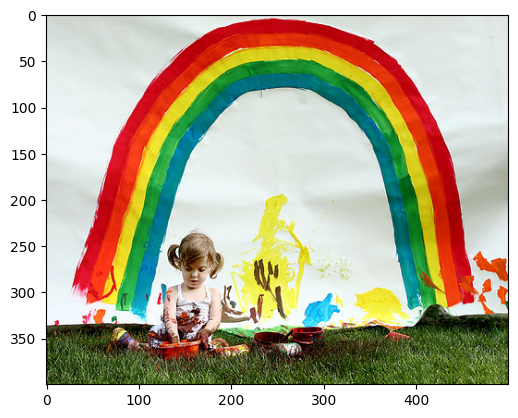

Prediction error: AttributeError("'list' object has no attribute 'strip'")
greedy no caption


In [153]:
ImgNum=2
pic = list(train_features.keys())[ImgNum]
# image = train_features[pic].reshape((1,2048))
x=plt.imread(images_path+pic+'.jpg')
plt.imshow(x)
plt.show()
# print("Greedy:",GreedySearch(supermodel,image))
print("greedy",prediction_pipeline(pic,'greedy',supermodel,train_features,ixtoword))
# print("Beam Search, K = 5:",BeamSearch(supermodel,image, beam_index = 5))
# print("Beam Search, K = 7:",BeamSearch(supermodel,image, beam_index = 7))
# print("Beam Search, K = 9:",BeamSearch(supermodel,image, beam_index = 9))
# print("Beam Search, K = 11:",BeamSearch(supermodel,image, beam_index =11))

#### Test images captions

In [ ]:
ImgNum=2
pic = list(test_features.keys())[ImgNum]
image = test_features[pic].reshape((1,2048))
x=plt.imread(pic)
plt.imshow(x)
plt.show()
print("Greedy:",GreedySearch(supermodel,image))
print("Beam Search, K = 3:",BeamSearch(supermodel,image, beam_index = 3))
print("Beam Search, K = 5:",BeamSearch(supermodel,image, beam_index = 5))
print("Beam Search, K = 7:",BeamSearch(supermodel,image, beam_index = 7))
print("Beam Search, K = 9:",BeamSearch(supermodel,image, beam_index = 9))
print("Beam Search, K = 11:",BeamSearch(supermodel,image, beam_index =11))


In [ ]:
# !rm -rf /kaggle/working/*